In [ ]:
from google.colab import drive
drive.mount('/drive')

from csv import reader
import pandas as pd
import ast

Mounted at /drive


In [ ]:
test = pd.read_csv('http://sybmo.com/thesis/test.csv')
test.tokens = test.tokens.apply(ast.literal_eval)
test.labels = test.labels.apply(ast.literal_eval)


final_list_tokens = []
final_list_labels = []

with open("/drive/My Drive/thesis_sybren/BERTs/spanBERT/spanBERT-addedvoca.csv", "r") as read_obj:
    csv_reader = reader(read_obj)
    # iterate over each row in the csv using reader object
    breaki = 0
    for row in csv_reader:
        # declare emtpy lists for every row
        words = []
        labels = []
        # row variable is a list that represents a row in csv
        for element in row:
            # turn string representation of tuple into real tuple
            element = ast.literal_eval(str(element))
            # append every first element of tuple to words list
            # if element[0] == "\u200d":
            #     print(row)
            words.append(element[0])

            # check if words start with bracket or double hashtag in order to only keep the right labels
            if not (element[0].startswith("[C") or element[0].startswith("##") or element[0].startswith("[S") ):
                labels.append(element[1])

        #remove "tokens" that start with bracket ([CLS] and [SEP] (but keep [UNK]))
        text = ' '.join([x for x in words if not (x.startswith('[C') or x.startswith('[S'))])
        clean_text = text.replace(' ##', '')


        split_fine_text = clean_text.split()

        # this piece of code finds emojis and removes them from the list
        # and removes the labels at given index
        for index, token in enumerate(split_fine_text):
            encoded_token = token.encode('utf8')
            if 'xf' in str(encoded_token):
                split_fine_text.pop(index)
                labels.pop(index)

        final_list_tokens.append(split_fine_text)
        final_list_labels.append([int(x[-1]) for x in labels])

        # breaki+=1
        # #if breaki > 10:
        #  #   break


# flatten the lists
preds = [item for sublist in final_list_labels for item in sublist]
gold = [item for sublist in test.labels.to_list() for item in sublist]
tokens_gold = [item for sublist in test.tokens.to_list() for item in sublist]
reconstructed_flat = [item for sublist in final_list_tokens for item in sublist]

In [ ]:
for index,token in enumerate(tokens_gold):
    if token == "\u200d":
        gold.pop(index)
        tokens_gold.pop(index)
        #preds.pop(index)

print(len(tokens_gold),len(reconstructed_flat),len(gold),len(preds))

14205 14205 14205 14205


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(gold, preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12493
           1       0.70      0.67      0.68      1192
           2       0.62      0.69      0.65       520

    accuracy                           0.93     14205
   macro avg       0.76      0.77      0.77     14205
weighted avg       0.93      0.93      0.93     14205



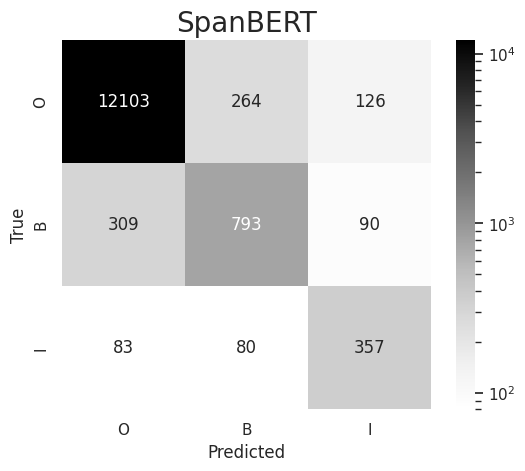

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='white')
from matplotlib.colors import LogNorm, Normalize
cm = metrics.confusion_matrix(gold, preds, labels=[0,1,2])
sns.heatmap(cm, cmap='Greys',annot=True,fmt='d',square=True, norm=LogNorm(), yticklabels = ['O','B','I'], xticklabels=['O','B','I']);

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title("SpanBERT", fontsize =20)
plt.savefig('SB-v3.pdf',dpi=200)
plt.show()

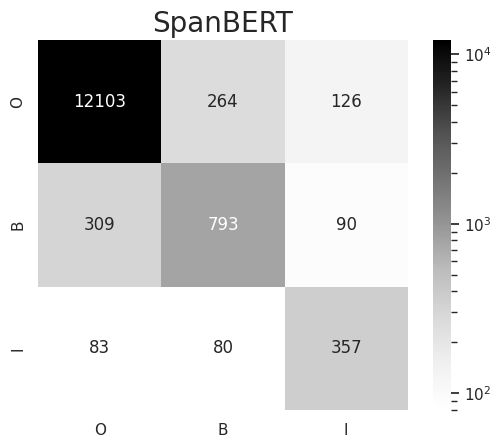

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='white')
from matplotlib.colors import LogNorm, Normalize

cm = metrics.confusion_matrix(gold, preds, labels=[0,1,2])
plt.title("SpanBERT", fontsize =20)
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(cm, cmap='Greys',annot=True,fmt='d',square=True, norm=LogNorm(), yticklabels = ['O','B','I'], xticklabels=['O','B','I']);
plt.savefig('spanbertv2.pdf',dpi=50)
plt.show()

In [ ]:
cm

array([[12103,   264,   126],
       [  309,   793,    90],
       [   83,    80,   357]])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

report = classification_report(gold, preds, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df)
df.to_latex()


,precision,recall,f1-score,support
0,0.968627,0.968783,0.968705,12493.000000
1,0.697449,0.665268,0.680979,1192.000000
2,0.623037,0.686538,0.653248,520.000000
accuracy,0.932981,0.932981,0.932981,0.932981
macro avg,0.763038,0.773530,0.767644,14205.000000
weighted avg,0.933221,0.932981,0.933013,14205.000000


<ipython-input-7-bed801b4e001>:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex()


'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  precision &    recall &  f1-score &       support \\\\\n\\midrule\n0            &   0.968627 &  0.968783 &  0.968705 &  12493.000000 \\\\\n1            &   0.697449 &  0.665268 &  0.680979 &   1192.000000 \\\\\n2            &   0.623037 &  0.686538 &  0.653248 &    520.000000 \\\\\naccuracy     &   0.932981 &  0.932981 &  0.932981 &      0.932981 \\\\\nmacro avg    &   0.763038 &  0.773530 &  0.767644 &  14205.000000 \\\\\nweighted avg &   0.933221 &  0.932981 &  0.933013 &  14205.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
zipped_list_labels = []

for sent_index,sentence in enumerate(final_list_tokens):
    sent_list = []
    for token_index, token in enumerate(sentence):
        sent_list.append((token, final_list_labels[sent_index][token_index]))
    zipped_list_labels.append(sent_list)

# #!pip install StringIO
# # from io import StringIO
# # s = StringIO.StringIO(text)
# with open('fileName.csv', 'w') as f:
#     for line in zipped_list_labels:
#         f.write(line)

import csv
with open("/drive/My Drive/thesis_sybren/BERTs/spanBERT/reconstructed_preds_spanBERT.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(zipped_list_labels)

In [ ]:
for index, token in enumerate(reconstructed_flat):
    if token != tokens_gold[index]:
        print(index,tokens_gold[index], token, gold[index], preds[index])

149 😂 [UNK] 0 0
1038 😂 [UNK] 0 0
1399 🤮 [UNK] 0 0
1400 🤮 [UNK] 0 0
1401 🤮 [UNK] 0 0
1402 🤮 [UNK] 0 0
1403 🤮 [UNK] 0 0
1404 🤮 [UNK] 0 0
1405 🤮 [UNK] 0 0
1406 🤮 [UNK] 0 0
1407 🤮 [UNK] 0 0
1408 🤮 [UNK] 0 0
1409 🤮 [UNK] 0 0
1410 🤮 [UNK] 0 0
1411 🤮 [UNK] 0 0
1412 🤮 [UNK] 0 0
1413 🤮 [UNK] 0 0
1414 🤮 [UNK] 0 0
1415 🤮 [UNK] 0 0
1416 🤮 [UNK] 0 0
1417 🤮 [UNK] 0 0
1418 🤮 [UNK] 0 0
1419 🤮 [UNK] 0 0
1420 🤮 [UNK] 0 0
1421 🤮 [UNK] 0 0
1422 🤮 [UNK] 0 0
1423 🤮 [UNK] 0 0
1424 🤮 [UNK] 0 0
1425 🤮 [UNK] 0 0
1426 🤮 [UNK] 0 0
1427 🤮 [UNK] 0 0
1428 🤮 [UNK] 0 0
1429 🤮 [UNK] 0 0
1430 🤮 [UNK] 0 0
1613 😹 [UNK] 0 0
1691 😍 [UNK] 0 0
2055 😇 [UNK] 0 0
2065 🙄 [UNK] 0 0
2550 😂 [UNK] 0 0
2551 😃 [UNK] 0 0
2552 😃 [UNK] 0 0
2610 ❤ [UNK] 0 0
2616 💔 [UNK] 0 0
2791 🤧 [UNK] 0 0
3032 🤗 [UNK] 0 0
3041 🤷 [UNK] 0 0
3042 🏽 [UNK] 0 0
3043 ♀️ [UNK] 0 0
3209 🖕 [UNK] 0 0
3210 🏽 [UNK] 0 0
3211 🖕 [UNK] 0 0
3212 🏽 [UNK] 0 0
3213 🖕 [UNK] 0 0
3214 🏽 [UNK] 0 0
3251 èire eire 0 0
3851 🤣 [UNK] 0 0
3852 🤣 [UNK] 0 0
3853 🤣 [UNK] 0 0
3854 🤣 [UNK]

In [ ]:
flat_aligned_tokens = [item for sublist in final_list_tokens for item in sublist]
len(pd.Series(flat_aligned_tokens)[pd.Series(flat_aligned_tokens)=='[UNK]'])

151